# Régression sans inversion

Ce notebook mesure le temps de calcul dans deux algorithmes pour résoudre une régression linéaire, le premier inverse un matrice, le second le fait sans inverser une matrice, le troisième reprend l'idée du second mais utilise une décomposition [QR](https://fr.wikipedia.org/wiki/D%C3%A9composition_QR) puis inverse la matrice *R*.

In [1]:
%matplotlib inline

In [2]:
import numpy.random as rnd
X = rnd.randn(1000, 7)
eps = rnd.randn(1000, 1) / 3
y = X.sum(axis=1).reshape((X.shape[0], 1)) + eps
X.shape, y.shape, eps.shape

((1000, 7), (1000, 1), (1000, 1))

In [3]:
from mlstatpy.ml.matrices import linear_regression, gram_schmidt
beta1 = linear_regression(X, y, algo=None)
beta2 = linear_regression(X, y, algo="gram")
beta1, beta2

(array([[1.01590078],
        [1.01155035],
        [1.01325728],
        [1.00008508],
        [0.99627926],
        [0.98079268],
        [0.99102198]]),
 array([1.01590078, 1.01155035, 1.01325728, 1.00008508, 0.99627926,
        0.98079268, 0.99102198]))

In [4]:
%timeit linear_regression(X, y, algo=None)

35.2 µs ± 972 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [5]:
%timeit linear_regression(X, y, algo="gram")

302 µs ± 16.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
%timeit linear_regression(X, y, algo="qr")

132 µs ± 753 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
Xt = X.T
%timeit gram_schmidt(Xt)

202 µs ± 9.91 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Un exemple avec [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [8]:
from sklearn.linear_model import LinearRegression
clr = LinearRegression()
%timeit clr.fit(X, y)

415 µs ± 9.41 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Qui utilise la fonction [lstsq](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html?highlight=lstsq):

In [9]:
from numpy.linalg import lstsq
%timeit lstsq(X, y, rcond=None)

969 µs ± 50.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Il serait sans doute possible d'optimiser les calculs en réduisant le nombre de copie et de transposées. La version utilisant une décomposition [QR](https://fr.wikipedia.org/wiki/D%C3%A9composition_QR) est assez rapide. Le code est là [matrices.py](https://github.com/sdpython/mlstatpy/blob/master/src/mlstatpy/ml/matrices.py). Pour dépasser [numpy](https://www.numpy.org/), il faut passer au C++. *scikit-learn* ajoute des étapes intermédiaires pour vérifier les données ce qui explique la longueur. On résume le tout par un graphique.

In [10]:
from cpyquickhelper.numbers import measure_time

In [11]:
stmts = [dict(name='lr_matrix', fct="linear_regression(X, y, algo=None)"),
         dict(name='lr_gram', fct="linear_regression(X, y, algo='gram')"),
         dict(name='lr_qr', fct="linear_regression(X, y, algo='qr')"),
         dict(name='gram', fct="gram_schmidt(Xt)"),
         dict(name='sklearn', fct="clr.fit(X, y)"),
         dict(name='lstsq', fct="lstsq(X, y)")]

memo = []
for size, dim in [(100, 10), (1000, 10), (10000, 10),
                  (100, 20), (1000, 20), (10000, 20),
                  (100, 50), (1000, 50)]:
    print(size, dim)
    X = rnd.randn(size, dim)
    eps = rnd.randn(size, 1) / 3
    y = X.sum(axis=1).reshape((X.shape[0], 1)) + eps
    context = dict(linear_regression=linear_regression, Xt=X.T,
                   X=X, y=y, gram_schmidt=gram_schmidt, clr=clr,
                   lstsq=lambda X, y: lstsq(X, y, rcond=None))
    
    for stmt in stmts:
        res = measure_time(stmt['fct'], number=20, repeat=20, div_by_number=True, context=context)
        res.update(stmt)
        res['size'] = size
        res['dim'] = dim
        memo.append(res)

import pandas
df = pandas.DataFrame(memo)
df.head()

100 10
1000 10
10000 10
100 20
1000 20
10000 20
100 50
1000 50


,average,context_size,deviation,dim,fct,max_exec,min_exec,name,number,repeat,size
0,0.000046,368,0.000007,10,"linear_regression(X, y, algo=None)",0.000056,0.000032,lr_matrix,20,20,100
1,0.000483,368,0.000268,10,"linear_regression(X, y, algo='gram')",0.001335,0.000325,lr_gram,20,20,100
2,0.000101,368,0.000007,10,"linear_regression(X, y, algo='qr')",0.000118,0.000095,lr_qr,20,20,100
3,0.000221,368,0.000031,10,gram_schmidt(Xt),0.000330,0.000205,gram,20,20,100
4,0.000507,368,0.000106,10,"clr.fit(X, y)",0.000722,0.000359,sklearn,20,20,100


In [12]:
piv = pandas.pivot_table(df, index=['size', 'dim'], columns='name', values='average')
piv

name           gram   lr_gram  lr_matrix     lr_qr     lstsq   sklearn
size  dim                                                             
100   10   0.000221  0.000483   0.000046  0.000101  0.000080  0.000507
      20   0.000614  0.000930   0.000055  0.000163  0.000142  0.000498
      50   0.001671  0.002652   0.000102  0.000349  0.000850  0.001020
1000  10   0.000390  0.000633   0.000057  0.000203  0.000146  0.000717
      20   0.001040  0.001397   0.000093  0.000381  0.000311  0.000784
      50   0.003278  0.004660   0.000384  0.000948  0.000971  0.001533
10000 10   0.001468  0.001582   0.000248  0.002149  0.000596  0.001918
      20   0.011930  0.012635   0.000312  0.006508  0.002522  0.006156

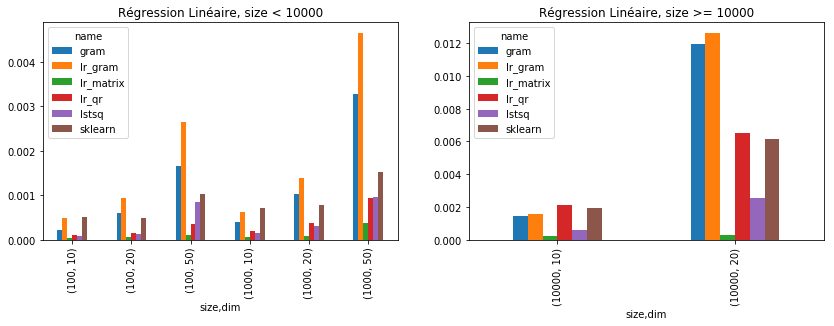

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14,4))
piv[:6].plot(kind="bar", ax=ax[0])
piv[6:].plot(kind="bar", ax=ax[1])
ax[0].set_title("Régression Linéaire, size < 10000")
ax[1].set_title("Régression Linéaire, size >= 10000");